In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


C:\Users\minhh\AppData\Local\Temp\ipykernel_14220\21078125.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df=pd.read_csv('../../Dataset/HSG Historical Data.csv')

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"15,500.0","15,250.0","15,700.0","15,250.0",15.49M,1.97%
1,06/01/2023,"15,200.0","15,300.0","15,350.0","14,950.0",15.03M,-1.30%
2,05/31/2023,"15,400.0","15,800.0","15,850.0","15,200.0",36.23M,-2.84%
3,05/30/2023,"15,850.0","15,800.0","16,000.0","15,600.0",13.35M,0.96%
4,05/29/2023,"15,700.0","15,500.0","15,700.0","15,350.0",9.60M,2.28%
...,...,...,...,...,...,...,...
1366,12/07/2017,"14,666.1","15,098.3","15,184.8","14,550.9",5.52M,-1.55%
1367,12/06/2017,"14,896.6","14,464.4","15,069.5","14,320.4",9.47M,2.58%
1368,12/05/2017,"14,522.1","15,040.7","15,242.4","14,522.1",12.28M,-1.75%
1369,12/04/2017,"14,781.4","14,061.0","14,781.4","13,830.5",13.71M,6.88%


In [4]:
# Checking null value
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [5]:
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [6]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [7]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15500.0,15250.0,15700.0,15250.0,15490000.0,0.0197
1,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-0.0130
2,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284
3,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
4,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
...,...,...,...,...,...,...,...
1366,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
1367,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
1368,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
1369,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688


In [8]:
df=df.sort_values(['Date'], ascending=[True])
df = df.reset_index(drop=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
1,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
3,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
4,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...,...
1366,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
1367,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
1368,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284
1369,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-0.0130


In [9]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,1371.000000,1371.000000,1371.000000,1371.000000,1.371000e+03,1371.000000
mean,14427.441284,14450.158133,14748.419037,14167.371335,9.892545e+06,0.000599
std,9763.865767,9787.401082,9961.580302,9603.698810,6.292617e+06,0.031914
min,3282.800000,3246.800000,3463.200000,3145.700000,8.300100e+05,-0.070000
25%,6031.700000,6033.050000,6132.800000,5955.700000,4.775000e+06,-0.016900
50%,12450.000000,12450.000000,12700.000000,12159.100000,8.760000e+06,0.000000
75%,17994.300000,18094.700000,18492.400000,17750.000000,1.371500e+07,0.017850
max,41541.700000,41750.000000,42750.000000,41333.300000,3.671000e+07,0.070000


In [10]:
fig = px.line(df, x=df.Date, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of HSG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [11]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int(len(df) * 0.6)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
df=df['Price']

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện: ", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra: ", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện:  (822,)
Số lượng mẫu trong tập kiểm tra:  (274,)
Số lượng mẫu trong tập valid:  (275,)


In [12]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# #Test for staionarity
# def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(12).std()
#     #Plot rolling statistics:
#     plt.plot(timeseries, color='blue',label='Original')
#     plt.plot(rolmean, color='red', label='Rolling Mean')
#     plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean and Standard Deviation')
#     plt.show(block=False)
    
#     print("Results of dickey fuller test")
#     adft = adfuller(timeseries,autolag='AIC')
#     # output for dft will give us without defining what the values are.
#     #hence we manually write what values does it explains using a for loop
#     output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
#     for key,values in adft[4].items():
#         output['critical value (%s)'%key] =  values
#     print(output)

In [13]:
# test_stationarity(train_data)

In [14]:
# train_data_diff = train_data.diff().dropna()
# test_stationarity(train_data_diff)

In [15]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf_original = plot_acf(train_data_diff)

# pacf_original = plot_pacf(train_data_diff)

In [16]:
from pmdarima.arima import auto_arima
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)
model=auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
# model = auto_arima(y_train, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=20, max_q=20, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=False, 
#                       stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12101.968, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=11907.925, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=11597.340, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.004 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -5796.670
Date:                Tue, 13 Jun 2023   AIC                          11597.340
Time:                        15:33:52   BIC               

In [17]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [18]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[21857.30892119 21934.31784238 22011.32676357 22088.33568476
 22165.34460595 22242.35352714 22319.36244833 22396.37136952
 22473.38029071 22550.3892119  22627.39813309 22704.40705428
 22781.41597547 22858.42489666 22935.43381785 23012.44273904
 23089.45166023 23166.46058142 23243.46950261 23320.4784238
 23397.48734499 23474.49626618 23551.50518737 23628.51410856
 23705.52302975 23782.53195094 23859.54087213 23936.54979332
 24013.55871451 24090.5676357 ]


In [19]:
# last_date=val_data.index[-1]
# forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
# forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])

# # Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(n_periods=len(forecast_df))

# # Print the predicted closing prices for the next 30 days
# print('Predicted closing prices for the next 30 days:')
# print(y_next_30_days)

In [20]:
# for i in range(len(forecast_df)):
#     forecast_df.loc[i, 'Close'] = y_next_30_days[i]

In [21]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)


Validation RMSE: 18877.63673427515
Testing RMSE: 7230.22711375229
Validation MAPE: 1.2574207874015586
Testing MAPE: 0.1944415369041524


Validation RMSE: 18877.63673427515
Testing RMSE: 7230.22711375229


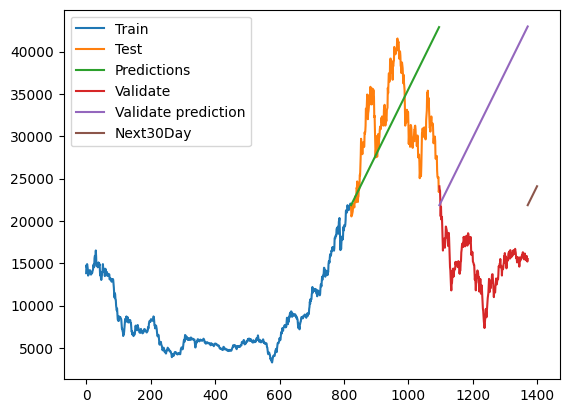

In [22]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate prediction','Next30Day'])
plt.show()

In [23]:
x_train = df.index.to_numpy()
y_train = values_array = df.values
model=auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21021.599, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21028.267, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21023.625, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21023.278, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21026.275, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21023.916, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21026.559, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21027.381, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21027.078, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21024.821, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21028.475, Time=0.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21028.556, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21016.759, Time=5.21 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(3,1,4)(0,0,0)[0] i

In [24]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[15608.87614881 15598.9054448  15505.13853846 15581.48248667
 15659.64671156 15556.72640294 15603.06244144 15651.20200038
 15563.17292346 15544.76934466 15622.06151379 15560.5919134
 15553.77043927 15628.67940781 15608.38251692 15563.49771361
 15622.324301   15600.03727522 15550.35060407 15588.45972024
 15603.83290294 15558.91360701 15595.86859886 15618.57299106
 15578.98725543 15584.8063247  15611.4257536  15572.41984542
 15571.7531302  15602.76961904]


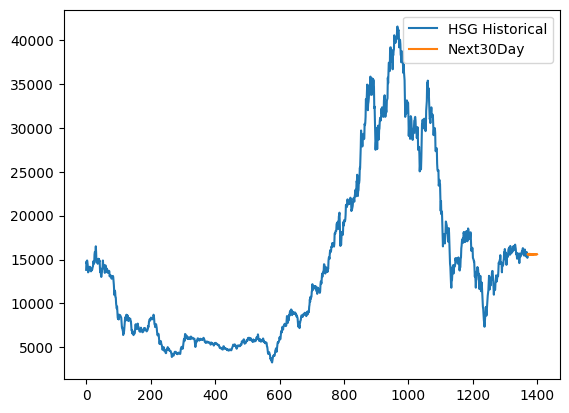

In [25]:
plt.plot(df.index, df.values)
plt.plot(last_data,y_next_30_days)
plt.legend(['HSG Historical', 'Next30Day'])
plt.show()